# RATIONAL MATRIX MACHINES

## Vector Fitting algorithm with expanded polynomial basis

## + Proximal Forward Backward Splitting algorithm for Pole-filtering regularization 

### a generalized L1-L2 group regularization for complex pole-residues feature space

>> ######    Homoscedastic & Heteroscedastic cases without polynomial background

##### a Python implementation by P. DUCRU


This program implements in Python 3 :
      - the simplest Vector Fitting algorithm (no complex conjugation for real case, no QR, no Relaxation, no othrogonal basis, etc.)
      - adds a polynomial entire part to the rational fit, of arbitrary order poly_order
      - Codes a PFBS algorithm for pole filtering

NOTE : author is Pablo DUCRU, for any inquires please e-mail at  *** p_ducru@mit.edu ***

In [1]:
## Import Python package for linear algebra
import numpy as np

In [2]:
## Import Python package for data management
#import pandas as pd

In [3]:
## Importing Python packages for plotting
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


### Rational Functions Space
The space of functions we are learning in is that of proper rational fraction of degree zero (poles + offset)

In [4]:
## Generic rational fractions with an offset and an entire part.
# > The entire part is specified by the set of coefficients.
# > If no coefficients are provided (the empty set), the rational function is build with a simple offset, the default value of which is zero.
def rational_function(z, poles, residues, offset=0, poly_coeff=()):
    if poly_coeff == ():
        poly_order = 0
        ## print("The rational_function function was not given an entire polynomial part to build.")
    else:
        poly_order = poly_coeff.shape[0]
    return  sum(residues[n]/(z-poles[n]) for n in range(poles.size)) + offset + sum(poly_coeff[n]*z**(n+1) for n in range(poly_order))

Metrics for rational function pole finding

In [5]:
## Function that measures the rate of missed poles: 1 = all poles missed 100% (i.e. either no poles to fit this true pole with, or fitted with zero a non-zero pole)
def poles_missing_rate(true_poles, fit_poles):
    miss = 0
    remaining_poles = fit_poles
    for true_pole in true_poles:
        if remaining_poles.size > 0:
            # find closest fit pole
            closest_pole = remaining_poles[np.argmin([np.abs( (true_pole - pole)/true_pole ) for pole in remaining_poles ])]
            # calculate how close (relatively) is the pole to the true poles
            miss += np.abs( (true_pole - closest_pole)/true_pole ) 
            # remove this pole the the remaining poles
            remaining_poles = remaining_poles[ [element != closest_pole for element in remaining_poles] ]
        elif remaining_poles.size == 0: #not enought fiting poles for the number of true poles
            miss += 1
    return miss/len(true_poles)

In [6]:
## Function that measures the rate of missed poles: 1 = all poles missed 100% (i.e. either no poles to fit this true pole with, or fitted with zero a non-zero pole)
def poles_overfitting_rate(true_poles, fit_poles):
    overfit = 0
    remaining_poles = true_poles
    for fit_pole in fit_poles:
        if remaining_poles.size > 0:
            # find closest true pole
            closest_pole = remaining_poles[np.argmin([np.abs( (fit_pole - pole)/pole ) for pole in remaining_poles ])]
            # calculate how close (relatively) is the fit pole to the true poles
            overfit += np.abs( (fit_pole - closest_pole)/closest_pole ) 
            # remove this pole the the remaining poles
            remaining_poles = remaining_poles[ [element != closest_pole for element in remaining_poles] ]
        elif remaining_poles.size == 0: #not enought fiting poles for the number of true poles
            overfit += 1
    return overfit/len(fit_poles)

In [7]:
## Function that measures the rate of finding all the poles, no more, no less (it gives 1 (100%) if all the poles are found exactly, and zero if all the poles are missed or all the poles are overfitted 100%)
def poles_finding_rate(true_poles, fit_poles):
    overfitting_rate = poles_overfitting_rate(true_poles, fit_poles)
    missing_rate = poles_missing_rate(true_poles, fit_poles)
    return 1 - max(missing_rate , overfitting_rate)

## Valling Vlad Module
Import training data

In [8]:
from rmm import utils as utils
x, data_1, data_2, true_value_1, true_value_2, poles, residues = utils.load_data("training_data/run1")
data_1 = data_1.view('float')
true_value_1 = true_value_1.view('float')

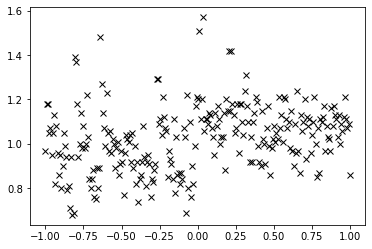

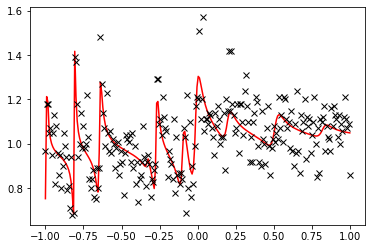

In [9]:
## Ploting the noisy training points upon the real data
fig_training_points = plt.figure()
#plt.plot(z_train, Y_true, 'r', label='Y_true')
plt.plot(x, data_1, 'x k', label = 'Y_train')
plt.show()

fig_training_points = plt.figure()
plt.plot(x, true_value_1, 'r', label='Y_true')
plt.plot(x, data_1, 'x k', label = 'Y_train')
plt.show()

In [10]:
z_train = x
Y_train = data_1
Y_train = Y_train.reshape((len(Y_train),1))
Y_true = true_value_1
Y_true = Y_true.reshape((len(Y_true),1))
true_poles = poles
true_residues = residues[:,0].reshape((len(residues),1))
number_true_poles = len(true_poles)
number_train_points = len(z_train)
true_offset = np.array([1])

In [11]:
data_1.shape

(250,)

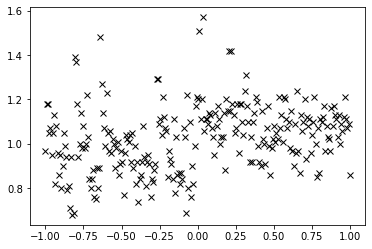

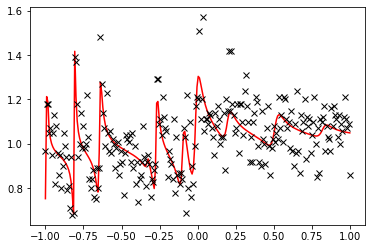

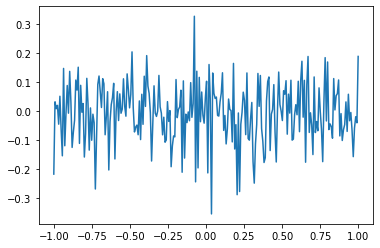

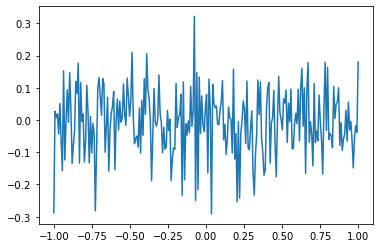

In [12]:
## Ploting the noisy training points upon the real data
fig_training_points = plt.figure()
#plt.plot(z_train, Y_true, 'r', label='Y_true')
plt.plot(z_train, Y_train, 'x k', label = 'Y_train')
plt.show()

fig_training_points = plt.figure()
plt.plot(z_train, Y_true, 'r', label='Y_true')
plt.plot(z_train, Y_train, 'x k', label = 'Y_train')
plt.show()

fig_training_points_diff = plt.figure()
plt.plot(z_train, Y_true - Y_train)
plt.show()


fig_training_points_rel_diff = plt.figure()
plt.plot(z_train, (Y_true - Y_train)/Y_true)
plt.show()

In [13]:
## build the square root of the rho_k weights for the LS system :: linear heteroscedastic case
def build_square_weights_rho_k(z_train, Y_train = ()):
    number_train_points = z_train.size
    sqrt_weights_rho = np.zeros([number_train_points], dtype=np.complex)
    for k in range(number_train_points):
        sqrt_weights_rho[k] =  1.0/(np.sqrt(number_train_points)) # CHANGE HERE FOR HETEROSKEDASTIC *(np.sqrt(np.linalg.norm(Y_train[k])))))  ## * (np.linalg.norm(Y_train[k])) ))) ## for linear heteroscedastic case, add: *np.linalg.norm(Y_train[k]))
    return sqrt_weights_rho

In [14]:
## define the Cauchy matrix
def Cauchy_matrix(z,p):
    C = np.zeros([z.size , p.size],  dtype=np.complex)
    for k in range(z.size):
        for j in range(p.size):
            C[k,j] = 1/(z[k] - p[j])
    return C

In [15]:
## define the Vandermonde matrix without offset
def Vandermonde_matrix(z,poly_order):
    V = np.zeros([z.size , poly_order],  dtype=np.complex)
    for k in range(z.size):
        for n in range(poly_order):
            V[k,n] = z[k]**(n+1)
    return V

In [16]:
## Create the Y_vector for the LS problem :: Here, we weight it with the sqrt of the rho_k for the system
def vectorize_Y_for_LS(z_train, Y_train, dim_residues):
    number_train_points = Y_train.shape[0]
    sqrt_weights_rho = build_square_weights_rho_k(z_train, Y_train)
    Y_LS_vector = np.zeros([dim_residues*number_train_points],  dtype=np.complex)
    for d in range(dim_residues):
        for k in range(number_train_points):
            Y_LS_vector[d*number_train_points + k] =  sqrt_weights_rho[k]*Y_train[k,d]
    return Y_LS_vector

In [17]:
## build the matrix of the barycentric LS system:
def build_barycentric_LS_matrix(z_train, Y_train, learn_poles, poly_order=0):
    dim_residues = Y_train[0].size
    number_train_points = z_train.size
    number_poles_learn = learn_poles.size
    sqrt_weights_rho = build_square_weights_rho_k(z_train, Y_train) 
    C = Cauchy_matrix(z_train, learn_poles)
    V = Vandermonde_matrix(z_train,poly_order)
    LS_matrix = np.zeros([dim_residues*number_train_points, dim_residues*(number_poles_learn+1+poly_order) + number_poles_learn],  dtype=np.complex)
    for d in range(dim_residues):
        for k in range(number_train_points):
            for p in range(number_poles_learn):
                LS_matrix[d*number_train_points + k, d*number_poles_learn + p] = sqrt_weights_rho[k]*C[k,p]
                for n in range(poly_order):
                    LS_matrix[d*number_train_points + k, dim_residues*number_poles_learn + d*poly_order + n] = sqrt_weights_rho[k]*V[k,n] 
                LS_matrix[d*number_train_points + k, dim_residues*(number_poles_learn+poly_order) + d] = sqrt_weights_rho[k]*1 
                LS_matrix[d*number_train_points + k, dim_residues*(number_poles_learn+poly_order+1) + p] = -sqrt_weights_rho[k]*Y_train[k,d]*C[k,p]
    return LS_matrix

In [18]:
## build the matrix of the simple LS system:
def build_LS_matrix(z_train, Y_train, learn_poles, poly_order=0):
    dim_residues = Y_train[0].size
    number_train_points = z_train.size
    number_poles_learn = learn_poles.size
    sqrt_weights_rho = build_square_weights_rho_k(z_train, Y_train) 
    C = Cauchy_matrix(z_train, learn_poles)
    V = Vandermonde_matrix(z_train,poly_order)
    LS_matrix = np.zeros([dim_residues*number_train_points, dim_residues*(number_poles_learn+1+poly_order) ],  dtype=np.complex)
    for d in range(dim_residues):
        for k in range(number_train_points):
            for p in range(number_poles_learn):
                LS_matrix[d*number_train_points + k, d*number_poles_learn + p] = sqrt_weights_rho[k]*C[k,p]  
                for n in range(poly_order):
                    LS_matrix[d*number_train_points + k, dim_residues*number_poles_learn + d*poly_order + n] = sqrt_weights_rho[k]*V[k,n] 
                LS_matrix[d*number_train_points + k, dim_residues*(number_poles_learn+poly_order) + d] = sqrt_weights_rho[k]*1 
    return LS_matrix

In [19]:
## Function that vectorizes the residues and offset for the problem
def build_LS_vector(residues, offset, poly_coeff=()):
    if type(poly_coeff) == tuple:
        poly_order = 0
        #print("The build_LS_vector function was not given an entire polynomial part to build.") 
    else:
        poly_order = poly_coeff.shape[0]
    number_poles = residues.shape[0]
    dim_residues = residues.shape[1]
    LS_vector    = np.zeros([dim_residues*(number_poles+poly_order+1)], dtype=np.complex)
    for d in range(dim_residues):
        for p in range(number_poles):
            LS_vector[d*number_poles + p] = residues[p][d]
        for n in range(poly_order):
            LS_vector[dim_residues*number_poles + d*poly_order + n] = poly_coeff[n][d]
    LS_vector[dim_residues*(number_poles+poly_order):LS_vector.size] = offset
    return LS_vector

In [20]:
## Function that takes the vectorized solution and spits out the different elements
def extract_from_LS_vector(LS_vector, number_poles, dim_residues , poly_order=0):
    residues = np.zeros([number_poles, dim_residues], dtype=np.complex)
    poly_coeff = np.zeros([poly_order, dim_residues], dtype=np.complex)
    offset   = np.zeros([dim_residues], dtype = np.complex)
    for d in range(dim_residues): 
        for p in range(number_poles):
            residues[p][d] = LS_vector[d*number_poles + p]
        for n in range(poly_order):
            poly_coeff[n][d] = LS_vector[dim_residues*number_poles + d*poly_order + n]
    offset = LS_vector[dim_residues*(number_poles+poly_order) : LS_vector.size]
    if poly_order == 0:
        return residues, offset
    else:
        return residues, poly_coeff, offset

**The Vector Fitting algorithm: **

The algorithm takes as input a training set {z_k, Y_k}, composed of training vectors {Y_k}, matched on a grid {z_k}.

A standard number of VF iterations is 10, which usually suffices to converge the poles. 

Our implementation does not require the input of an initial guess. If you do not give one, the program will come up with a linearly spaced complex diagonal along the rectangle of the mesh of training points on the complex plane. 

In [21]:
def VF_algorithm(z_train, Y_train, number_VF_iteration, poly_order = 0 , *arguments ):
    ## build the Y vector to solve for:
    dim_residues = Y_train[0].size
    number_train_points = z_train.size
    Y_LS_vector = vectorize_Y_for_LS(z_train, Y_train, dim_residues)
    ## Initialize the poles
    if arguments == ():
        raise AssertionError("The VF_algorithm function must be given either a number of poles, or an array of initial poles guess") 
    for arg in arguments:
        if type(arg) == np.ndarray: ## was given an initial guess as argument
            print(" The VF_algorithm was provided an initial guess for the poles")
            learn_poles = arg
            number_poles = learn_poles.size
        elif type(arg) == int: ## was given a number of poles without any initial guess
            print("The VF_algorithm was provided a number of poles to learn and is generating an initial guess")
            number_poles = arg
            if (np.amax(np.imag(z_train)) - np.amin(np.imag(z_train))) == 0: ## only real training data
                print("The training points are only along the real axis, and the initial guesses are generated accordingly with a shift")
                learn_poles = np.linspace(np.amin(np.real(z_train))+1/(10*(np.amax(np.real(z_train)) - np.amin(np.real(z_train)))),np.amax(np.real(z_train)) + 1/(10*(np.amin(np.real(z_train))-np.amax(np.real(z_train)))) , number_poles) + 1j*np.linspace(np.amin(np.imag(z_train)),np.amax(np.imag(z_train)), number_poles)
            elif (np.amax(np.real(z_train)) - np.amin(np.real(z_train)) ) == 0:
                print("The training points are exactly along the imaginary axis, and the initial guesses are generated accordingly with a shift")
                learn_poles = np.linspace(np.amin(np.real(z_train)),np.amax(np.real(z_train)) , number_poles) + 1j*np.linspace(np.amin(np.imag(z_train)) + 1/(10*(np.amax(np.imag(z_train)) - np.amin(np.imag(z_train)))) ,np.amax(np.imag(z_train)) - 1/(10*(np.amax(np.imag(z_train)) - np.amin(np.imag(z_train)))), number_poles)
            else:
                learn_poles = np.linspace(np.amin(np.real(z_train))+1/(10*(np.amax(np.real(z_train))-np.amin(np.real(z_train)))),np.amax(np.real(z_train)) - 1/(10*(np.amax(np.real(z_train)) - np.amin(np.real(z_train)))) , number_poles) + 1j*np.linspace(np.amin(np.imag(z_train)) + 1/(10*(np.amax(np.imag(z_train)) - np.amin(np.imag(z_train)))), np.amax(np.imag(z_train)) -  1/(10*(np.amax(np.imag(z_train)) - np.amin(np.imag(z_train)))) , number_poles)
    ## POLE CONVERGENCE: Run the VF iterations 
    for i in range(number_VF_iteration):
        ## build the barycentric L2 system
        barycentric_LS_matrix = build_barycentric_LS_matrix(z_train, Y_train, learn_poles, poly_order)
        ## solve the barycentric L2 system
        barycentric_LS_vector , barycentric_LS_residual , barycentric_LS_rank , barycentric_LS_singular_values = np.linalg.lstsq(barycentric_LS_matrix, Y_LS_vector, poly_order)
        ## extract the barycentric residues
        barycentric_residues = barycentric_LS_vector[dim_residues*(learn_poles.size + poly_order +1):barycentric_LS_vector.size]
        ## Build the matrix the spectrum of which will be the recolated poles
        P = np.diag(learn_poles) - np.tensordot(barycentric_residues,np.ones([barycentric_residues.size], dtype=np.complex),0)
        ## Solve the spectral problem & relocate poles
        learn_poles , eigenvectors = np.linalg.eig(P)
        ## convergence criteria
    ## RESIDUES EXTRACTION: Solve the LS system
    ## build the quadratic system
    LS_matrix = build_LS_matrix(z_train, Y_train, learn_poles, poly_order)
    ## solve the quadratic L2 system
    LS_vector, LS_residual, LS_rank , LS_singular_values = np.linalg.lstsq(LS_matrix, Y_LS_vector) ## np.linalg.solve(A.T.dot(A) + lamb * np.identity(n_col), A.T.dot(y)) For Tichonov
    ## extract the residues, polynomial coefficients and offset
    if poly_order == 0:
        VF_poly_coeff= np.array([ 0.0 for n in range(poly_order)])
        VF_residues , VF_offset = extract_from_LS_vector(LS_vector, learn_poles.size, dim_residues)
        return learn_poles, VF_residues, VF_poly_coeff, VF_offset, LS_residual, barycentric_residues ## Artificially added an emplty set of VF_poly_coeff for homogeneity
    else:
        VF_residues , VF_poly_coeff, VF_offset = extract_from_LS_vector(LS_vector, learn_poles.size, dim_residues, poly_order)
        return learn_poles, VF_residues, VF_poly_coeff, VF_offset, LS_residual, barycentric_residues

#### Results benchmarking and analysis


VF algorithm results

In [22]:
VF_poles, VF_residues, VF_poly_coeff, VF_offset, VF_residual, barycentric_residues = VF_algorithm(z_train, Y_train, 30, 0, 25) ## add VF_poly_coeff when poly_order not zero 

The VF_algorithm was provided a number of poles to learn and is generating an initial guess
The training points are only along the real axis, and the initial guesses are generated accordingly with a shift
<ipython-input-21-3c12cea54245>:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  LS_vector, LS_residual, LS_rank , LS_singular_values = np.linalg.lstsq(LS_matrix, Y_LS_vector) ## np.linalg.solve(A.T.dot(A) + lamb * np.identity(n_col), A.T.dot(y)) For Tichonov


In [23]:
## VF results
z_train  ## for complex values : 2*np.random.rand(number_CV_points)*np.exp(1j*2*np.pi*np.random.rand(number_CV_points))
dim_residues = Y_train[0].size
Y_VF = np.zeros([z_train.size, dim_residues] , dtype=complex) ## VF solution
for k in range(z_train.size):
    Y_VF[k] = rational_function(z_train[k], VF_poles, VF_residues, VF_offset) # add when poly_order not zero : VF_poly_coeff)

Plotting Vector Fitting results

/usr/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


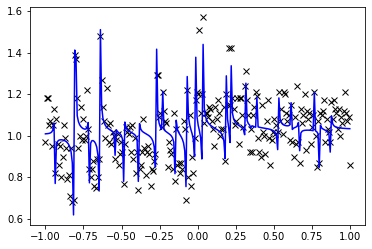

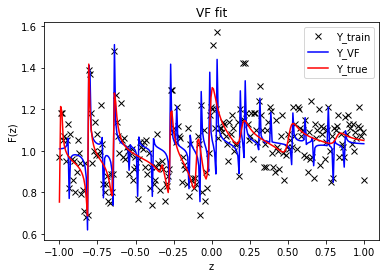

In [24]:
fig_train_vs_VF = plt.figure()
plt.plot(z_train, Y_train, 'x k', label='Y_train' )
plt.plot(z_train, Y_VF, 'b', label='Y_VF')
#plt.plot(z_train, Y_true, 'r', label='Y_true')

fig_train_vs_VF = plt.figure()
plt.plot(z_train, Y_train, 'x k', label='Y_train' )
plt.plot(z_train, Y_VF, 'b', label='Y_VF')
plt.plot(z_train, Y_true, 'r', label='Y_true')

#plt.ylim(-20,20)
plt.xlabel('z')
plt.ylabel('F(z)')
plot_title = 'VF fit'
plt.title(plot_title)
plt.legend()
#plt.show()
plt.rcParams['axes.facecolor'] = '0.98'


In [25]:
VF_poles

array([-0.93745635-8.96469364e-112j, -0.81103556+3.99800753e-111j,
       -0.79962121-7.13128675e-111j,  0.87434742+4.56914003e-111j,
       -0.71237551-5.81875786e-111j,  0.80011324-9.18515837e-112j,
        0.76702959+1.78717350e-110j,  0.66886781-1.29882494e-110j,
        0.61519555+7.56723786e-111j, -0.64139858-2.07399589e-111j,
       -0.54146073+1.50029588e-111j, -0.48456277+1.73567036e-110j,
        0.5307463 +5.43220542e-111j, -0.38822731-4.35541853e-111j,
        0.38945184-4.05850561e-112j,  0.34996377+2.59152428e-111j,
        0.315932  -3.20194779e-111j,  0.21882275+2.86192796e-111j,
        0.18606269+1.41700653e-111j, -0.27139177+1.36815933e-111j,
       -0.22913897+3.06239794e-111j,  0.0337792 -8.12124206e-111j,
       -0.01421199-6.79902223e-113j, -0.14642466+7.62060519e-111j,
       -0.07213976-1.34027209e-110j])

## RMM filtering for different Delta options

We here define a pole-filtering regularization, as explained in the equations of article here:
https://www.overleaf.com/read/vjrwkmvhdzdg

In [26]:
## Proximal operator for L1-L2 group regularization
def prox_λ(A,λ):
    return A*max(0,1-λ/np.linalg.norm(A))

In [34]:
def delta_one_LASSO(z_train, poles, Y_train = ()):
    delta_one = 1
    return delta_one

def delta_min_distance(z_train, poles, Y_train = ()):
    min_distances_z_p = np.zeros(len(poles), dtype=complex )
    for p in range(poles.size):
        min_distances_z_p[p] = np.abs(poles[p] - z_train[0])
        for k in range(z_train.size):
            if np.abs(poles[p] - z_train[k]) < min_distances_z_p[p] :
                min_distances_z_p[p] = np.abs(poles[p] - z_train[k])
    return min_distances_z_p

def delta_min_distance_sq(z_train,poles, Y_train = ()):
    value = delta_min_distance(z_train,poles)
    return value**2

def delta_learning_rate(z_train, poles, Y_train=()):
    Delta = np.zeros(len(poles) , dtype=complex )
    sqrt_weights_rho = build_square_weights_rho_k(z_train) 
    for p in range(poles.size):
        gamma_R_p_inv = 0
        for k in range(z_train.size):
            gamma_R_p_inv += 2*(sqrt_weights_rho[k]/np.abs(z_train[k] - poles[p]) )**2
        Delta[p] = (1/gamma_R_p_inv)**0.5
    return Delta 

def delta_learning_rate_sq(z_train, poles, Y_train=()):
    value = delta_learning_rate(z_train, poles, Y_train)
    return value**2

def delta_average_pole(z_train, poles, Y_train = ()):
    Delta = np.zeros(len(poles) , dtype=complex )
    rho = build_square_weights_rho_k(z_train)**2 
    for p in range(poles.size):
        temp = 0
        for k in range(z_train.size):
            temp += rho[k]/np.abs(z_train[k] - poles[p])
        Delta[p] = 1/temp
    return Delta

def delta_average_sq_pole(z_train, poles, Y_train = ()):
    Delta = np.zeros(len(poles) , dtype=complex )
    rho = build_square_weights_rho_k(z_train)**2 
    for p in range(poles.size):
        temp = 0
        for k in range(z_train.size):
            temp += (rho[k]/np.abs(z_train[k] - poles[p]))**2
        Delta[p] = 1/temp
    return Delta 

def delta_average_pole_sq(z_train, poles, Y_train = ()):
    value = delta_average_pole(z_train, poles, Y_train)
    return value**2


def delta_inv_im_real(z_train, poles, Y_train = ()):
    Delta = np.zeros(len(poles) , dtype=complex )
    for p, pole in enumerate(poles):
        Delta[p] = 1/np.real(pole) + 1/np.imag(pole)
    return Delta 


def delta_inv_im_real_sq(z_train, poles, Y_train = ()):
    value = delta_inv_im_real(z_train, poles, Y_train)
    return value**2

In [35]:
def RMM_pole_filtering(delta_function, z_train, Y_train, poles , λ=0 , μ=0, num_PFBS_iter = 2000 , ε = 1.0e-8):
    ## build the LS vectors and matrix
    number_poles = poles.size
    dim_residues = Y_train[0].size
    Y_LS_vector = vectorize_Y_for_LS(z_train, Y_train, dim_residues)
    Z = build_LS_matrix(z_train, Y_train, poles)
    ## calculate the least distances from z_k to poles:
    Δ = delta_function(z_train, poles, Y_train)
    ## calculate the γ step size
    ZZ = np.tensordot(Z.conj().T,Z,1)
    eigenvals , eigenvects = np.linalg.eig(ZZ)
    γ = 1/(2*np.amax(eigenvals))
    ## condition number of this system
    Condition_number = np.amax(eigenvals)/np.amin(eigenvals)
    ## initiatilze the PFBS descent with the LS residues
    LS_vector, LS_residual, LS_rank , LS_singular_values = np.linalg.lstsq(Z, Y_LS_vector)
    PFBS_vector = LS_vector
    ## start PFBS iterations
    PFBS_iter_num = 0
    for i in range(num_PFBS_iter):
        ## report the old vector
        PFBS_old_residues, PFBS_old_offset = extract_from_LS_vector(PFBS_vector,number_poles, dim_residues)
        ## iteration count
        PFBS_iter_num += 1 
        ## compute the Gradient
        ΔE = 2*np.tensordot(Z.conj().T, (np.tensordot(Z,PFBS_vector, 1) - Y_LS_vector), 1)
        ## Add the Tichonov regularization on the residues
        ΔEμ = ΔE 
        ΔEμ[:dim_residues*number_poles] = ΔE[:dim_residues*number_poles] + 2*μ*PFBS_vector[:dim_residues*number_poles]
        ## take the Gradient descent step
        GD_new_PFBS_vector = PFBS_vector - γ*ΔEμ
        GD_new_residues, GD_new_offset = extract_from_LS_vector(GD_new_PFBS_vector, number_poles, dim_residues)
        ## take the PFBS step for group LASSO regularization
        PFBS_new_residues = GD_new_residues
        ΔL2_relative_step_size = np.zeros([number_poles])
        for p in range(number_poles):
            PFBS_new_residues[p] = prox_λ(GD_new_residues[p],λ/Δ[p])
            ## calculate the PFBS step size for convergence criteria
            if np.linalg.norm(PFBS_new_residues[p]) == 0:
                ΔL2_relative_step_size[p] = 0
            else: 
                ΔL2_relative_step_size[p] = np.linalg.norm(PFBS_new_residues[p] - PFBS_old_residues[p])/(np.linalg.norm(PFBS_new_residues[p]))
        ## update PFBS_vector
        PFBS_vector = build_LS_vector(PFBS_new_residues, GD_new_offset)
        ## convergence criteria on the relative step size 
        if np.amax(ΔL2_relative_step_size) < ε:
            print("The λ regularization parameter is λ =", λ, "the maximum relative step sizes in norm is max(ΔL2_relative_step_size) =" , np.amax(ΔL2_relative_step_size), "for threshold ε =", ε, "and the PFBS iterations are breaking after PFBS_iter_num =", PFBS_iter_num, "iterations")
            break
    PFBS_residues, PFBS_offset = extract_from_LS_vector(PFBS_vector, number_poles, dim_residues)
    return PFBS_residues, PFBS_offset , γ , Condition_number, PFBS_iter_num

#### Results of the Pole Filtering Regularization

Pole Filtering trumps L1-L2 group regularization

In [36]:
regularizing_functions = [delta_min_distance, delta_min_distance_sq,delta_average_pole,delta_average_sq_pole,delta_average_pole_sq,delta_learning_rate,delta_learning_rate_sq,delta_inv_im_real]
lambdas = [1e-9, 1e-12, 5*1e-8, 1e-8, 1e-8,1e-8,1e-8,1e-8]
Y_output = []
for jj, regularizer in enumerate(regularizing_functions):
    RMM_residues, RMM_offset , γ , RMM_Condition_number, RMM_iter_num = RMM_pole_filtering(regularizer, z_train, Y_train, VF_poles , lambdas[jj], 0.0)
    ## Pole filtered results
    z_train  ## for complex values : 2*np.random.rand(number_CV_points)*np.exp(1j*2*np.pi*np.random.rand(number_CV_points))
    dim_residues = Y_train[0].size
    Y_RMM = np.zeros([z_train.size, dim_residues] , dtype=complex) 
    for k in range(z_train.size):
        Y_RMM[k] = rational_function(z_train[k], VF_poles, RMM_residues, RMM_offset )
    Y_output.append(Y_RMM)

<ipython-input-35-61777d85be8e>:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  LS_vector, LS_residual, LS_rank , LS_singular_values = np.linalg.lstsq(Z, Y_LS_vector)
The λ regularization parameter is λ = 1e-08 the maximum relative step sizes in norm is max(ΔL2_relative_step_size) = 0.0 for threshold ε = 1e-08 and the PFBS iterations are breaking after PFBS_iter_num = 133 iterations
The λ regularization parameter is λ = 1e-08 the maximum relative step sizes in norm is max(ΔL2_relative_step_size) = 3.0957063971581676e-13 for threshold ε = 1e-08 and the PFBS iterations are breaking after PFBS_iter_num = 1 iterations


/usr/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


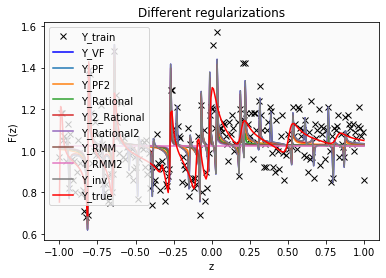

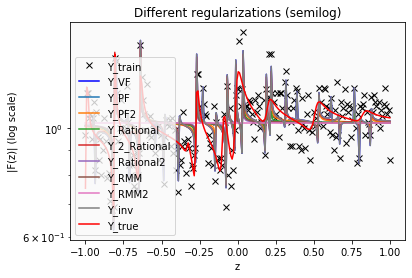

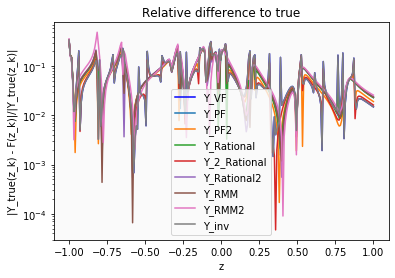

In [37]:
## Plotting PFBS results v/s VF results v/s the true model data (log-space data is in absolute value)
labels = ["Y_PF", "Y_PF2",  "Y_Rational", "Y_2_Rational","Y_Rational2", "Y_RMM", "Y_RMM2","Y_inv"]
plt.figure()
plot_title = 'Different regularizations'
plt.plot(z_train, Y_train, 'x k', label='Y_train' )
plt.plot(z_train, Y_VF, 'b', label='Y_VF' )
#plt.plot(z_train, Y_PFBS, 'g', label='Y_PFBS')
for ii, label in enumerate(labels):
    plt.plot(z_train, Y_output[ii],label = label)
plt.plot(z_train, Y_true, 'r', label='Y_true' )
#plt.ylim(-10, 20)
plt.xlabel('z')
plt.ylabel('F(z)')
plt.title(plot_title)
plt.legend()
pdf_title = "%s.%s"%(plot_title , 'pdf')
plt.savefig(pdf_title)

plt.figure()
plot_title = 'Different regularizations (semilog)'
plt.semilogy(z_train, np.abs(Y_train), 'x k', label='Y_train' )
plt.semilogy(z_train, np.abs(Y_VF), 'b', label='Y_VF' )
#plt.semilogy(z_train, np.abs(Y_PFBS), 'g', label='Y_PFBS')
for ii, label in enumerate(labels):
    plt.semilogy(z_train, Y_output[ii],label = label)
plt.semilogy(z_train, np.abs(Y_true), 'r', label='Y_true' )
#plt.ylim(-10, 20)
plt.xlabel('z')
plt.ylabel('|F(z)| (log scale)')
plt.title(plot_title)
plt.legend()
pdf_title = "%s.%s"%(plot_title , 'pdf')
plt.savefig(pdf_title)

plt.figure()
plot_title = 'Relative difference to true'
plt.semilogy(z_train, np.abs((Y_true - Y_VF)/Y_true), 'b', label='Y_VF' )
#plt.semilogy(z_train, np.abs((Y_true - Y_PFBS)/Y_true), 'g', label='Y_PFBS')
for ii, label in enumerate(labels):
    plt.semilogy(z_train, np.abs((Y_true - Y_output[ii])/Y_true),label = label)
#plt.ylim(-10, 20)
plt.xlabel('z')
plt.ylabel('|Y_true(z_k) - F(z_k)|/|Y_true(z_k)|')
plt.title(plot_title)
plt.legend()
#plt.show()
pdf_title = "%s.%s"%(plot_title , 'pdf')
plt.savefig(pdf_title)

## Remaining (to be done)

There are only 3 things remaining at this stage: 
> • benchmark the VF alroghtm: in particular its ability to catch all the right poles if provided with (noisy) data. Because in the end we are supposing that VF would if given the right amount of poles. What if this is not the case?

> • Test which pole filtering regularization works best.

> • Test pole v/s residues regularization for final result with the right nuber of poles. 

> • It is likely that all the results depend on the form of the noise. Choose the right noise. 

> • Test RMM v/s brute force VF on time and performance. 

> • Implement and test the validity of the adaptive learning rates $\gamma_n = \frac{1}{2\sum_k \frac{\rho_k}{|z_k - p_n|^2}}$
 
 > • Propose, implement, and test relationship between noise and lambda $\lambda \sim \sigma$ with $\sigma \sim \sum_k \rho_k \left\| F(z_k) - Y_k \right\|_2^2$ 
 
 > • Test of real-case problem: oxygen-16 (good example because ENDF does not give the resonance parameters, so we can only "blindly" fit the date, and observe wether we find what R-matrix theory finds. If these are neutral-particle chanels, the fundamental assumption that we are searching for rational functions is valid, and then we are indeed testing the poerformance of the Rational Matrix Machine on noisy date for a real case. If it finds the exact solution, we could claim we have a "New Machine Learning Algorithm Learns Nuclear Physics", which is sexy enought, certainly for ICML, but if the algorithm is very good, why not in Nature Communciations. 

## Feature selection | Residues finding
Comparing the performance of Tichonov regularization, residues dampening regularization (with squares?), and direct least-squares